# Clean With IR

Replica of `with_ir.ipynb` organized into two sections. Each section can be run on its own.

## 1. Make the mesh

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gmsh
from dolfinx import fem
import pandas as pd
import numpy as np

from mesh_and_materials.mesh import *
from mesh_and_materials.materials import *
from space.space_and_forms import *
from dirichlet_bc.bc import *

In [3]:

# Sample geometry (all units in meters)

d_ins_oside = 6.3e-6
d_ins_pside = 3.2e-6
d_sample    = 1.84e-6
d_ir        = 0.062e-6

# Mesh bounds
x_length = d_ins_oside + d_ins_pside + d_sample + 2 * d_ir
mesh_xmin, mesh_xmax = -(x_length/2), x_length/2
mesh_ymin, mesh_ymax = -20e-6, 0.0


In [4]:

# Material regions (from left to right)
bx_ins_pside = mesh_xmin
BX_ins_pside = mesh_xmin + d_ins_pside

bx_ir_pside  = BX_ins_pside
BX_ir_pside  = bx_ir_pside + d_ir

bx_sample = BX_ir_pside
BX_sample = bx_sample + d_sample

bx_ir_oside = BX_sample
BX_ir_oside = bx_ir_oside + d_ir

bx_ins_oside = BX_ir_oside
BX_ins_oside = bx_ins_oside + d_ins_oside

ins_pside = Material(
    "pside ins",
    [bx_ins_pside, BX_ins_pside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

ir_pside = Material(
    "pside ir",
    boundaries=[bx_ir_pside, BX_ir_pside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

sample = Material(
    "sample",
    boundaries=[bx_sample, BX_sample, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 5164 * 1158, "k": 3.9},
    mesh_size=0.08e-6
)

ir_oside = Material(
    "oside ir",
    boundaries=[bx_ir_oside, BX_ir_oside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

ins_oside = Material(
    "oside ins",
    boundaries=[bx_ins_oside, BX_ins_oside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

materials = [ins_pside, ir_pside, sample, ir_oside, ins_oside]

gmsh_domain = Mesh(
    name="clean",
    boundaries=[mesh_xmin, mesh_xmax, mesh_ymin, mesh_ymax],
    materials=materials
)


In [5]:
gmsh_domain.build_mesh()

no mesh errors found
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [100%] Meshing curve 19 (Line)
Info    : Done meshing 1D (Wall 0.00598118s, CPU 0.007143s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 4 (Plan

In [6]:
gmsh_domain.write('clean_with_ir.msh')
# Visualize in gmsh if desired
gmsh.open('clean_with_ir.msh')
gmsh.fltk.initialize()
gmsh.fltk.run()

Info    : Writing 'clean_with_ir.msh'...
Info    : Done writing 'clean_with_ir.msh'
Info    : Reading 'clean_with_ir.msh'...
Info    : 33 entities
Info    : 205776 nodes
Info    : 410885 elements                                                                                     
Info    : Done reading 'clean_with_ir.msh'                                                                       
-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240524
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[

## 2. Run the simulation

In [7]:

# Experimental heating curve

df = pd.read_csv('experimental_data/geballe_2020_fig3_left_approx.csv')
df = df.copy().iloc[1:].reset_index(drop=True)

# split front/back columns and clean
df_pside = df[['Front', 'Unnamed: 1']].copy()
df_oside = df[['Back',  'Unnamed: 3']].copy()

df_pside.columns = ['time', 'temperature']
df_oside.columns = ['time', 'temperature']

df_pside = (df_pside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_oside = (df_oside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_pside['time'] = df_pside['time'] * 10**-6
df_oside['time'] = df_oside['time'] * 10**-6

df_pside['normed temperature'] = (
    df_pside['temperature'] - df_pside['temperature'].iloc[0]
) / (df_pside['temperature'].max() - df_pside['temperature'].min())

df_oside['normed temperature'] = (
    df_oside['temperature'] - df_oside['temperature'].iloc[0]
) / (df_pside['temperature'].max() - df_pside['temperature'].min())


In [10]:
import os
rebuild_mesh = False
mesh_file = 'clean_with_ir.msh'
if not os.path.exists(mesh_file) or rebuild_mesh:
    gmsh_domain.build_mesh()
    gmsh_domain.write(mesh_file)

dolfinx_domain = Mesh.msh_to_dolfinx(mesh_file)


Info    : Reading 'clean_with_ir.msh'...
Info    : 33 entities
Info    : 205776 nodes
Info    : 410885 elements                                                                                     
Info    : Done reading 'clean_with_ir.msh'                                                                       


In [11]:

spaces = Space(dolfinx_domain, V_family='Lagrange', V_degree=1, Q_family='DG', Q_degree=0)

rho_cv_fxn = spaces.assign_material_property(materials, 'rho_cv')
k_fxn = spaces.assign_material_property(materials, 'k')


In [12]:

ic_temp = 300.0
ic_fxn = spaces.initial_condition(ic_temp)
u_n = fem.Function(spaces.V)
u_n.x.array[:] = ic_fxn.x.array
u_n.x.scatter_forward()


In [13]:

from scipy.interpolate import make_interp_spline

pside_heating_spline_interp = make_interp_spline(df_pside['time'], df_pside['temperature'], k=3)
offset = df_pside['temperature'].iloc[0] - 300

def heating_offset(t):
    return float(pside_heating_spline_interp(t)) - offset

# Gaussian profile for inner boundary
heating_FWHM = 13.2e-6
coeff = -4.0 * np.log(2.0) / heating_FWHM**2
y_center = 0.0

def gaussian(x, y, t):
    amp = heating_offset(t)
    return (amp - ic_temp) * np.exp(coeff * (y - y_center)**2) + ic_temp

bcs = []
left_bc = RowDirichletBC(spaces.V, 'left', value=ic_temp)
right_bc = RowDirichletBC(spaces.V, 'right', value=ic_temp)
bottom_bc = RowDirichletBC(spaces.V, 'bottom', value=ic_temp)
inner_bc = RowDirichletBC(
    spaces.V,
    'x',
    coord=bx_ir_pside,
    length=heating_FWHM * 2,
    center=0.0,
    value=gaussian,
)

obj_bcs = [left_bc, right_bc, bottom_bc, inner_bc]
bcs = [bc.bc for bc in obj_bcs]


In [14]:
RowDirichletBC.describe_row_bcs(obj_bcs)

Row BC #0: x in [-5.732e-06, -5.732e-06]  y in [-2.000e-05, 1.583e-24]  (n = 201 DOFs)
Row BC #1: x in [5.732e-06, 5.732e-06]  y in [-2.000e-05, -9.525e-24]  (n = 201 DOFs)
Row BC #2: x in [-5.732e-06, 5.732e-06]  y in [-2.000e-05, -2.000e-05]  (n = 135 DOFs)
Row BC #3: x in [-2.532e-06, -2.532e-06]  y in [-1.320e-05, 2.642e-25]  (n = 661 DOFs)


In [15]:

from dolfinx.fem.petsc import assemble_matrix

time_stop = 7.0e-6
num_steps = 200
dt = time_stop/num_steps

a_form, L_form = spaces.build_variational_forms(rho_cv_fxn, k_fxn, u_n, dt)
A = assemble_matrix(spaces.a_form, bcs=bcs)
A.assemble()

b = fem.petsc.create_vector(L_form)

solver = PETSc.KSP().create(A.getComm())
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


In [17]:
from io_utilities.xdmf_utils import *

outputs_folder = os.path.join(os.getcwd(), 'sim_outputs')
save_folder = os.path.join(outputs_folder, 'clean_with_ir')
os.makedirs(save_folder, exist_ok=True)

xdmf = init_xdmf(spaces.mesh, save_folder, 'solution')
uh = fem.Function(spaces.V)
uh.name = 'Temperature (K)'
uh.interpolate(ic_fxn)
xdmf.write_function(uh, 0.0)


In [18]:

for x in obj_bcs:
    x.update(0.0)

progress_interval = max(1, num_steps // 10)
for step in range(num_steps):
    t = (step+1)*dt
    inner_bc.update(t)

    with b.localForm() as local_b:
        local_b.set(0)
    fem.petsc.assemble_vector(b, L_form)
    fem.petsc.apply_lifting(b, [a_form], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bcs)

    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    u_n.x.array[:] = uh.x.array

    xdmf.write_function(uh, t)

    if (step + 1) % progress_interval == 0 or (step + 1) == num_steps:
        percent = int((step + 1) / num_steps * 100)
        print(f"Simulation progress: {percent}% (step {step + 1}/{num_steps})")

xdmf.close()


Simulation progress: 10% (step 20/200)
Simulation progress: 20% (step 40/200)
Simulation progress: 30% (step 60/200)
Simulation progress: 40% (step 80/200)
Simulation progress: 50% (step 100/200)
Simulation progress: 60% (step 120/200)
Simulation progress: 70% (step 140/200)
Simulation progress: 80% (step 160/200)
Simulation progress: 90% (step 180/200)
Simulation progress: 100% (step 200/200)


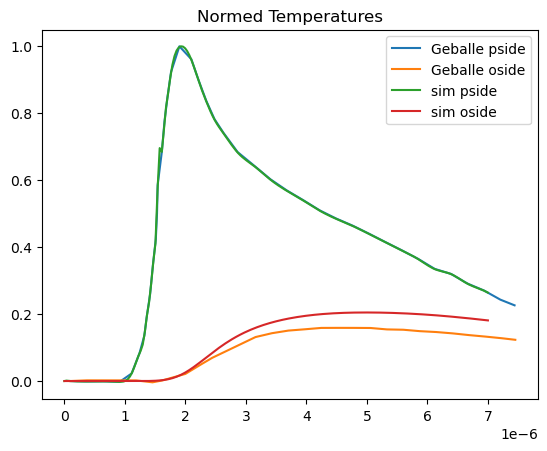

In [19]:
from io_utilities.xdmf_extract import *

time, data = extract_point_timeseries_xdmf(
    os.path.join(save_folder, 'solution.xdmf'),
    function_name='Temperature (K)',
    query_points=[(bx_ir_pside, 0), (BX_ir_oside, 0)]
)

sim_df = pd.DataFrame({'time': time,
                       'pside': data[0],
                       'oside': data[1]})

sim_df['normed pside'] = (sim_df['pside'] - sim_df['pside'].iloc[0]) / (sim_df['pside'].max() - sim_df['pside'].min())
sim_df['normed oside'] = (sim_df['oside'] - sim_df['oside'].iloc[0]) / (sim_df['pside'].max() - sim_df['pside'].min())

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title('Normed Temperatures')
ax.plot(df_pside['time'], df_pside['normed temperature'], label='Geballe pside')
ax.plot(df_oside['time'], df_oside['normed temperature'], label='Geballe oside')
ax.plot(sim_df['time'], sim_df['normed pside'], label='sim pside')
ax.plot(sim_df['time'], sim_df['normed oside'], label='sim oside')
ax.legend()
plt.show()


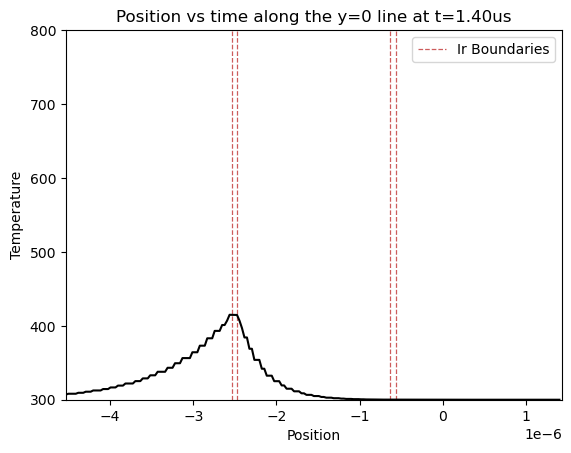

In [20]:

query_points = []
xmin = bx_ir_pside - 2e-6
xmax = BX_ir_oside + 2e-6
samples = 200

for x in np.linspace(xmin, xmax, samples):
    query_points.append((x, 0.0))

time, data = extract_point_timeseries_xdmf(
    os.path.join(save_folder, 'solution.xdmf'),
    function_name='Temperature (K)',
    query_points=query_points
)
locations = np.arange(data.shape[0])

sim_df = pd.DataFrame(data, index=locations.astype(int), columns=time)

fig, ax = plt.subplots()

t0 = 40
location_series = (locations/samples) * (xmax - xmin) + xmin
ymin = 300
ymax = 800

ax.plot(location_series, sim_df.iloc[:, t0], zorder = 3, color = 'black')
ax.vlines([BX_sample, bx_sample, bx_ir_pside, BX_ir_oside], ymin=ymin, ymax=ymax, ls='--', label='Ir Boundaries', color='indianred', zorder=2, lw=0.9)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Position')
ax.set_ylabel('Temperature')
ax.set_title(f'Position vs time along the y=0 line at t={t0*dt*1e6:.2f}us')
ax.legend()
plt.show()
